# Bose Hubbard model via Skolem Tridiagonalization 

In [1]:
import os

threads = 1
os.environ['NUMEXPR_MAX_THREADS'] = '{}'.format(threads)
os.environ['NUMEXPR_NUM_THREADS'] = '{}'.format(threads)
os.environ['OMP_NUM_THREADS'] = '{}'.format(threads)
os.environ['MKL_NUM_THREADS'] = '{}'.format(threads)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.linalg import eigh_tridiagonal, norm, hankel, expm
from scipy.sparse import block_diag

# from tqdm.notebook import tqdm, trange
import time

# Number theoretical tools: The Skolem polynomials and its inverse
from skolem_util import skolem, tuple_from_skolem

from quspin.operators import hamiltonian # Hamiltonians and operators
from quspin.basis import boson_basis_1d # Hilbert space boson basis

## Parameters of the 3 sites Bose Hubbard model and propagation

In [3]:
U = 1
J = 1
mu = 0

# number of bosons
N = 100

# time-step for propagation 
Δt = 0.01

# times to save wavefunctions
times = Δt * np.arange(100)

# number of sites 
K = 4

# If True – the periodic boundary condition, False – the open boundary condition
is_pbc = False

## Using the Skolem for building the propagator  the Bose Hubbard model 

In [4]:
t0 = time.time()

# the cut off of Skolem index
S_min = skolem((K - 1) * [0] + [N])
S_max = skolem([N] + (K - 1) * [0])

skolem_indx = np.arange(S_min, S_max + 1)

# This should be parallelized to speed up 
#  or replaced by boson_basis_1d[::-1] from QuSpin since they are compatible (see the comment below) 
n = np.array(
    [tuple_from_skolem(S, K) for S in skolem_indx]
).T

########################################################
# Reindexing to implement the permutation matrix 
# to bring the neighboring site to tridiagonal form.
########################################################

# This is included to be compatible with QuSpin
minus = -1

# indx implements the shift matrix S in the paper, 
# i.e.,  \Psi[indx] implements S\Psi  
indx = np.array([
    skolem(_) for _ in n[np.roll(np.arange(K), minus * 1)].T
])
indx -= S_min

########################################################
# The following re-ordering is to be compartible with QuSpin
n = n[::-1]
# Now the basis in QuSpin and in the Skolemn propagator coincide

### Get $\exp(-i\Delta t \hat{H}_{nn})$ via block tridiagonalization
where $\hat{H}_{nn}$ stands for nearest neighbor hamiltonian

In [5]:
# diagonal of the tri-diagonal Hamiltonian H_nn
d = -(mu + 0.5 * U) * n[-2] + 0.5 * U * n[-2] ** 2

# off diagonal of the full tri-diagonal Hamiltonian H23
e = -J * np.sqrt((n[-2] + 1) * n[-1])[1:]

start_block = 0

# Find the edges of the blocks. They are found when the off-diagonals have zeros   
block_edges = np.where(e == 0)[0] + 1

if block_edges[-1] != d.size:
    block_edges = np.append(block_edges, [d.size])

expH_nn = []

# Find matrix exponential via diagonalization of each block separately
for end_block in block_edges:
    block_E_nn, block_v = eigh_tridiagonal(
        d[start_block:end_block],
        e[start_block:end_block - 1],
    )
    
    expH_nn.append(
        (block_v * np.exp(-1j * Δt * block_E_nn)) @ block_v.T
    )

    start_block = end_block
    
# Save as a sparse matrix
expH_nn = block_diag(expH_nn)

# Open boundary condition
if not is_pbc:
    # extra phase factor (due to the on-site interaction) 
    # that needs to be taken into account in the case of the open boundary condition
    d_edge = d -(mu + 0.5 * U) * n[-1] + 0.5 * U * n[-1] ** 2
 
    expH_edge = []
    
    start_block = 0
    
    # Find matrix exponential via diagonalization of each block separately
    for end_block in block_edges:
        block_E_nn, block_v = eigh_tridiagonal(
            d_edge[start_block:end_block],
            e[start_block:end_block - 1],
        )

        expH_edge.append(
            (block_v * np.exp(-1j * Δt * block_E_nn)) @ block_v.T
        )

        start_block = end_block
        
    # Save as a sparse matrix
    expH_edge = block_diag(expH_edge)

# Save time it took to initialize the Skolem propagator 
time_prepare_skolem = time.time() - t0

## QuSpin

Comparing the implementation of the Bose-Hubbard Model in the QuSpin library by following: https://github.com/weinbe58/QuSpin/blob/master/examples/notebooks/BHM.ipynb

In [6]:
##### construct Bose-Hubbard Hamiltonian #####
# define boson basis with N states per site L bosons in the lattice

basis = boson_basis_1d(K, Nb=N) # full boson basis

# define site-coupling lists
if is_pbc:
    # Peridodic bouundary condition
    hop=[[-J,i,(i+1)%K] for i in range(K)] #PBC
else:
    # open boundary condition
    hop=[[-J,i,(i+1)%K] for i in range(K - 1)]

interact=[[0.5*U,i,i] for i in range(K)] # U/2 \sum_j n_j n_j
pot=[[-mu-0.5*U,i] for i in range(K)] # -(\mu + U/2) \sum_j j_n

# define static and dynamic lists
static=[['+-',hop],['-+',hop],['n',pot],['nn',interact]]
dynamic=[]

# build Hamiltonian
H=hamiltonian(static,dynamic,basis=basis,dtype=np.float64)

Hermiticity check passed!
Particle conservation check passed!


/home/denys/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Test for symmetries not implemented for <class 'quspin.basis.basis_1d.boson.boson_basis_1d'>, to turn off this warning set check_symm=False in hamiltonian


## Comparing the propagators with QuSpin

### Initial condition

In [7]:
ψ0 = np.zeros(len(basis.states), complex)
ψ0[0] = 1

### QuSpin evolution

In [8]:
t0 = time.time()

Ψ_quspin = H.evolve(ψ0, times[0], times)

print("QuSpin run time {:.1f} s".format(time.time() - t0))

QuSpin run time 260.4 s


### Skolem evolution

In [9]:
t0 = time.time()

Ψ_skolem = [ψ0,]


if is_pbc:
    # Peridodic bouundary condition
    for _ in times[1:]:

        ψ = Ψ_skolem[-1]

        for _ in range(K):
            ψ = expH_nn @ ψ[indx]

        Ψ_skolem.append(ψ)
else:
    # Open boundary condition
    for _ in times[1:]:

        ψ = expH_edge @ Ψ_skolem[-1][indx][indx]
        
        for _ in range(2, K):            
            ψ = expH_nn @ ψ[indx] 
               
        Ψ_skolem.append(ψ)
  
    
Ψ_skolem = np.array(Ψ_skolem).T

time_propagate_skolem = time.time() - t0

print("Preparation of basis and Skolem diagonalization: {:.1f} s".format(time_prepare_skolem))
print("Skolem propagation: {:.1f} s".format(time_propagate_skolem))

print("Total Skolem method run time {:.1f} s".format(time_prepare_skolem + time_propagate_skolem))

Preparation of basis and Skolem diagonalization: 23.0 s
Skolem propagation: 8.9 s
Total Skolem method run time 31.9 s


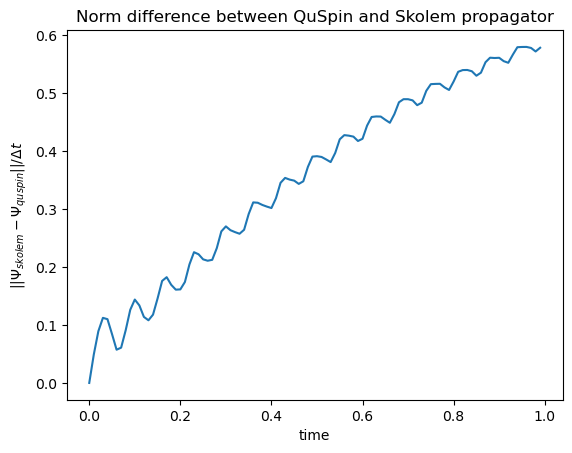

In [10]:
plt.title("Norm difference between QuSpin and Skolem propagator")
plt.plot(times, norm(Ψ_skolem - Ψ_quspin, axis=0) / Δt)
plt.xlabel("time")
plt.ylabel(r"$\|\|\Psi_{skolem} - \Psi_{quspin}\|\| / \Delta t$")
plt.show()

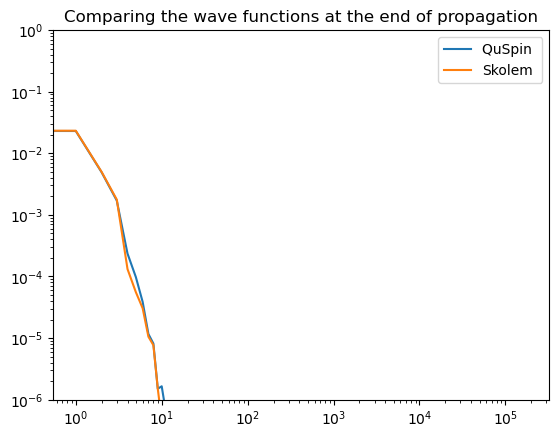

In [11]:
plt.title("Comparing the wave functions at the end of propagation")
plt.loglog(np.abs(Ψ_quspin[:, -1]) ** 2, label='QuSpin ')
plt.loglog(np.abs(Ψ_skolem[:, -1]) ** 2, label='Skolem')
plt.ylim([1e-6, 1e0,])
plt.legend()
plt.show()